In [2]:
import numpy as np
import math as m
import scipy
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol


# Problem 1

## SVD

In [3]:
A = [[4,2], 
     [2,1]]
U, V, DT = np.linalg.svd(A)

In [4]:
V

array([5.00000000e+00, 1.39218791e-17])

## Pivoted QR

In [5]:
Q,R,P = scipy.linalg.qr(A, pivoting=True)


In [6]:
R

array([[-4.47213595e+00, -2.23606798e+00],
       [ 0.00000000e+00, -1.55651340e-17]])

# Problem 2

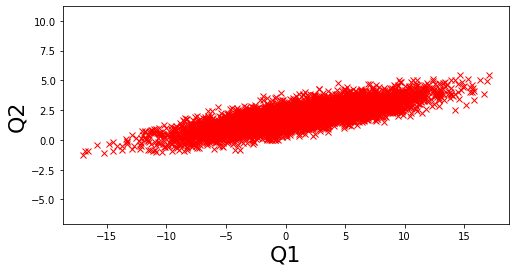

In [370]:
plt.figure(figsize=(8,4))
mean = [1,2]
cov = [[25,4],[4,1]]
Q1, Q2 = np.random.multivariate_normal(mean, cov, 6000).T
plt.plot(Q1, Q2, 'rx')
plt.axis('equal')
plt.xlabel("Q1", fontsize = 22)
plt.ylabel("Q2", fontsize = 22)
plt.savefig("P2_scatter.eps")

In [371]:
N = 100
h = 1/N
Y = []
X = []

for i in range (1,101):
    x = i*h
    Q1, Q2 = np.random.multivariate_normal(mean, cov, 1).T
    y = Q1+Q2*x
    X.append(x)
    Y.append(y)

A = np.ones((np.size(X),2))  
A[:,1] = X

# Least Square fit parameter estimation
B = np.matmul(A.T,A)
conditionNo = np.linalg.cond(B)
C = np.matmul(A.T,Y)

D= np.matmul(np.linalg.inv(B),C)

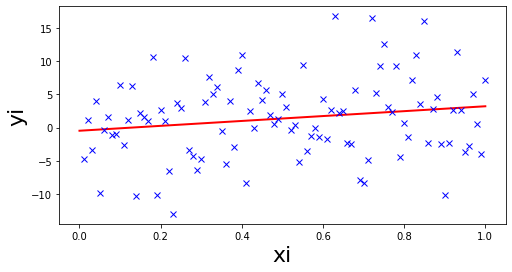

In [372]:
plt.figure(figsize=(8,4))
X2 = np.linspace(0,1,1000)
plt.plot(X2,D[0]+D[1]*X2,'r',linewidth=2)
plt.plot(X,Y,'bx')
plt.xlabel("xi", fontsize = 22)
plt.ylabel("yi", fontsize = 22)
plt.savefig("P2_fit.eps")

In [10]:
conditionNo

19.444890911233593

# Problem 3

In [305]:
def T(x,phi,h):
    a    = 0.95
    b    = 0.95
    k    = 2.37
    L    = 70
    Tamb = 30
    #x    = 50
    gamma = np.sqrt(2*(a+b)*h/(a*b*k))
    c1 =  -1*(phi/(k*gamma))*((m.e**(gamma*L)*(h+k*gamma))/(m.e**(-1*gamma*L)*(h-k*gamma)+m.e**(gamma*L)*(h+k*gamma)))
    c2 = (phi/(k*gamma))+c1
    temp = c1*m.e**(-1*gamma*x)+c2*m.e**(gamma*x)+Tamb
    return(temp)

In [306]:
problem = {
    'num_vars':2,
    'names':['Phi','h'],
    'bounds':[[0,1]]*2
}

param_values =saltelli.sample(problem,2**6)

#evaluate
x = np.linspace(0,70,100)
y = np.array([T(x, *params) for params in param_values])

# Analyze
sobol_indices = [sobol.analyze(problem, Y) for Y in y.T]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

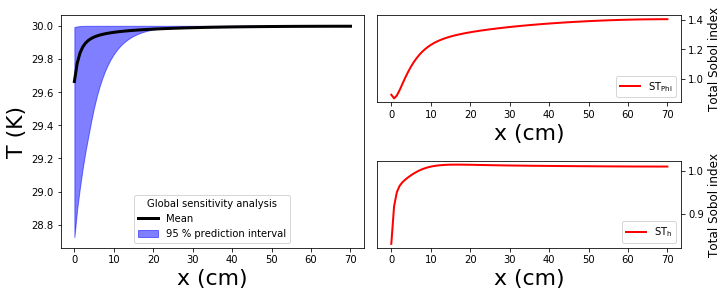

In [307]:
S1s = np.array([s['ST'] for s in sobol_indices])

fig = plt.figure(figsize=(10, 4), constrained_layout=True)
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[:, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 1])

for i, ax in enumerate([ax1, ax2]):
    ax.plot(x, S1s[:, i],
            label=r'ST$_\mathregular{{{}}}$'.format(problem["names"][i]),
            color='red',linewidth=2)
    ax.set_xlabel("x (cm)",fontsize=22)
    ax.set_ylabel("Total Sobol index" ,fontsize =12)

    #ax.set_ylim(0, 1.04)

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.legend(loc='lower right')

ax0.plot(x, np.mean(y, axis=0), label="Mean", color='black',linewidth=3)

# in percent
prediction_interval = 95

ax0.fill_between(x,
                 np.percentile(y, 50 - prediction_interval/2., axis=0),
                 np.percentile(y, 50 + prediction_interval/2., axis=0),
                 alpha=0.5, color='blue',
                 label=f"{prediction_interval} % prediction interval")

ax0.set_xlabel("x (cm)", fontsize = 22)
ax0.set_ylabel("T (K)" ,fontsize=22)
ax0.legend(title=r"Global sensitivity analysis",
           loc='lower center')._legend_box.align = "center"

#plt.show()
plt.savefig("P3_Sobol.eps")

# Problem 4

In [191]:
def z(K,z1,t):
    om = 0.5*np.sqrt(4*K-.15**2)
    exp = m.e**(-.5*.15*t)
    A = 2*np.cos(om*t)
    B = (z1+.15)*np.sin(om*t)/om
    temp = exp*(A+B)
    return(temp)

def dzdK(K,z1,t):
    om = 0.5*np.sqrt(4*K-.15**2)
    exp = m.e**(-.5*.15*t)/(2*om)
    A = -2*t*np.sin(om*t)
    B = (-(z1+.15)/om**2)*np.sin(om*t)
    C = (z1+.15)*t*np.cos(om*t)/om
    temp = exp*(A+B+C)
    return (temp)

def dzdz1(K,z1,t):
    om = 0.5*np.sqrt(4*K-.15**2)
    exp = m.e**(-.5*.15*t)/(om)
    A = np.sin(om*t)
    temp = exp*A
    return (temp)

In [296]:
t  = np.linspace(.01,5,500)
X  = np.zeros((2,np.size(t)))
X1 = np.zeros(np.size(t))
X2 = np.zeros(np.size(t))
Z  = []
for i in range (0,np.size(t)):
    K0  = 20
    z10 = 10
    T  = t[i]
    K  = K0 +np.random.normal(0,.1,size=None)
    z1 = z10+np.random.normal(0,.1,size=None)
    z2 = z(K,z1,T)
    Z.append(z2)
    X[0,i]   = dzdK(K,z1,T)
    X[1,i]   = dzdz1(K,z1,T)

B = np.matmul(X,X.T)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


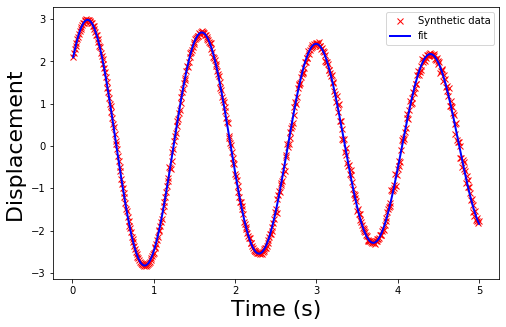

In [297]:
plt.figure(figsize=(8,5))
plt.plot(t,Z,'rx',label='Synthetic data')
plt.plot(t,z(K0,z10,t),'b',linewidth=2,label='fit')
plt.xlabel("Time (s)", fontsize = 22)
plt.ylabel("Displacement ", fontsize = 22)
plt.legend()
plt.savefig('P4_1.eps')

In [302]:
np.linalg.inv(B)

array([[0.00996084, 0.0247754 ],
       [0.0247754 , 0.17642623]])

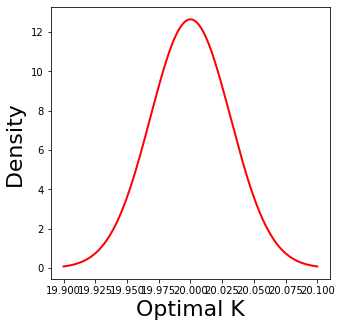

In [303]:
plt.figure(figsize=(5,5))
x = np.linspace(19.9,20.1,1000)
y = scipy.stats.norm(20, np.sqrt(0.1*.00996084))
plt.plot(x,y.pdf(x),'r',linewidth=2)
plt.xlabel("Optimal K", fontsize = 22)
plt.ylabel("Density ", fontsize = 22)
plt.savefig('P4_K.eps')

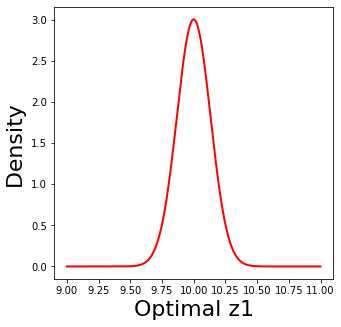

In [304]:
plt.figure(figsize=(5,5))
x = np.linspace(9.,11,1000)
y = scipy.stats.norm(10, np.sqrt(.1*0.17642623))
plt.plot(x,y.pdf(x),'r',linewidth=2)
plt.xlabel("Optimal z1", fontsize = 22)
plt.ylabel("Density ", fontsize = 22)
plt.savefig('P4_z1.eps')

# Problem 5

In [392]:
def T22(x,phi,h):
    a    = 0.95
    b    = 0.95
    k    = 4.01
    L    = 70
    Tamb = 21.29
    gamma = 1.02469*np.sqrt(h)
    c1_1  = -1*phi/(k*gamma)
    ep = m.e**(gamma*L)*(h+k*gamma)
    en = m.e**(-1*gamma*L)*(h-k*gamma)
    c1_2 = ep/(en+ep)
    c1 = c1_1*c1_2
    c2 = (phi/(k*gamma))+c1
    return (c1*m.e**(-1*gamma*x)+c2*m.e**(gamma*x)+Tamb)
    

In [411]:
from scipy import optimize
x    = np.array([10,14,18,22,26,30,34,38,42,46,50,54,58,62,66])
temp = np.array([66.04,60.04,54.81,50.42,46.74,43.66,40.76,38.49,36.42,34.77,33.18,32.36,31.56,30.91,30.56])
gues = 60*np.ones(np.size(x))  


popt, pcov = optimize.curve_fit(T22, x, temp, p0 = [5,.001])#, bounds=(0, [3., 1., 0.5]))

popt

array([-9.61103630e+00,  1.32927018e-03])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


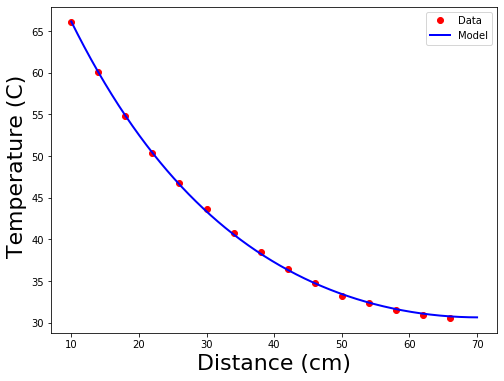

In [430]:
plt.figure(figsize=(8,6))
plt.plot(x,temp,'ro',label='Data')
x1 = np.linspace(10,70,1000)
plt.plot(x1,T22(x1,-9.611  , .00133),'b',linewidth=2,label='Model')
plt.xlabel("Distance (cm)", fontsize = 22)
plt.ylabel(" Temperature (C)", fontsize = 22)
plt.legend()
plt.savefig("P5_fit.eps")

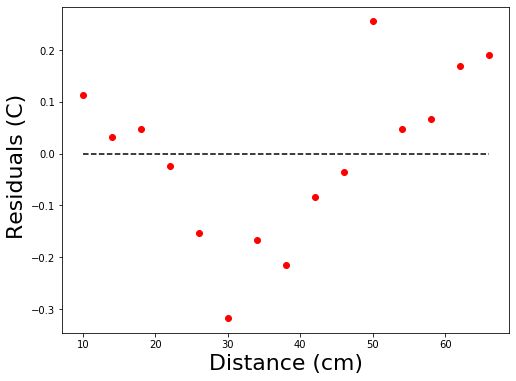

In [431]:
plt.figure(figsize=(8,6))
Res = -1*(temp-T22(x,-9.611  , .00133))
plt.plot(x,Res,'ro')
plt.plot(x,np.zeros(np.size(x)),'k--')
plt.xlabel("Distance (cm)", fontsize = 22)
plt.ylabel(" Residuals (C)", fontsize = 22)
plt.savefig("P5_res.eps")


In [435]:
Res2 = Res**2
np.sqrt(np.sum(Res2))

0.6006537657539195

In [436]:
pcov

array([[ 4.12114998e-03, -5.35591508e-07],
       [-5.35591508e-07,  7.52323326e-11]])